In [2]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

For each query, change the raw reward to f(reward) = sigma(reward - best_of_1_reward).

Use f(reward) to train a new probe.

Route using the calibrated_probs from the new probe.

In [40]:
# read the csv files.
df_train = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/chat_train_df.csv")
df_test = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/chat_test_df.csv")
df_test_classified = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/sept-19/df_test_classified.csv")
df_train_classified = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/sept-19/df_train_classified.csv")

In [41]:
df_train.shape, df_train_classified.shape

((88852, 13), (88852, 14))

In [ ]:
x_train_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/train-features/X.npy"
x_train = np.load(x_train_path)
x_test_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/test-features/X.npy"
x_test = np.load(x_test_path)

x_train.shape, x_test.shape

# save the features as .npy files in rewards_normalized.
# np.save("/dccstor/gma2/mehuldamani/search-and-learn/rewards_normalized/X_train.npy", x_train)
# np.save("/dccstor/gma2/mehuldamani/search-and-learn/rewards_normalized/X_test.npy", x_test)


In [42]:
y_train_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/train-features/y.npy"
y_train = np.load(y_train_path)
y_test_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/test-features/y.npy"
y_test = np.load(y_test_path)


In [43]:
df_train_classified.shape, df_test_classified.shape, y_train.shape, y_test.shape

((88852, 14), (22298, 17), (88852,), (22298,))

In [62]:
# For each question, find the row where N=1 and method=best_of_n, and get its 'sl' value.
# Create a new column 'best_of_1_reward' in df_train_classified with this value for each question.

# First, get the best_of_1 sl values for each question
bon_sl = df_train_classified[(df_train_classified["N"] == 1) & (df_train_classified["method"] == "best_of_n")][["question", "sl"]]
bon_sl = bon_sl.rename(columns={"sl": "best_of_1_reward"})

# Merge this back into the original dataframe, keeping all rows from df_train_classified
df_train_classified_after_bon = df_train_classified.merge(bon_sl, on="question", how="left")

In [63]:
df_train_classified['question'].nunique(), df_train_classified.shape

(3930, (88852, 14))

In [64]:
df_train_classified_after_bon['question'].nunique(), df_train_classified_after_bon.shape

(3930, (93799, 15))

In [67]:
# keep only the rows in df_train_classified_after_bon that are in df_train_classified.
df_train_classified_after_bon = df_train_classified_after_bon[df_train_classified_after_bon.index.isin(df_train_classified.index)]
df_train_classified_after_bon.shape

(88852, 15)

In [18]:
# best_of_1_reward is giving the correct reward.
# df_train_classified[(df_train_classified["N"] == 1) & (df_train_classified["method"] == "best_of_n")].head()

In [68]:
import scipy.special
df_train_classified_after_bon["normalized_reward"] = scipy.special.expit(df_train_classified_after_bon["sl"] - df_train_classified_after_bon["best_of_1_reward"])

Save normalized rewards as the response for probe-training.

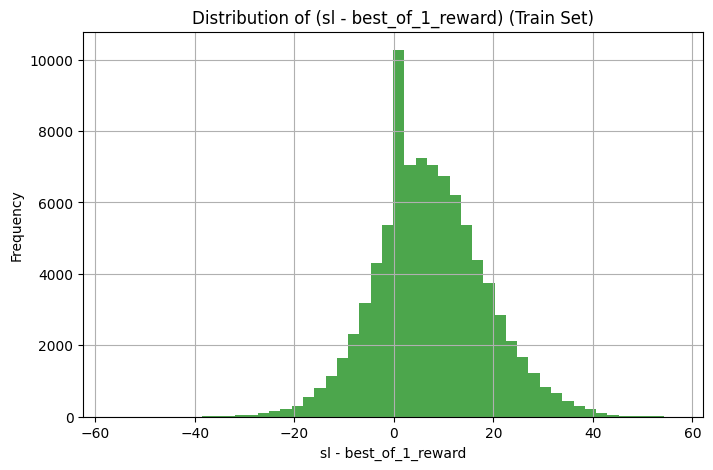

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_train_classified_after_bon["sl"] - df_train_classified_after_bon["best_of_1_reward"], bins=50, alpha=0.7, color='green')
plt.xlabel("sl - best_of_1_reward")
plt.ylabel("Frequency")
plt.title("Distribution of (sl - best_of_1_reward) (Train Set)")
plt.grid(True)
plt.show()


In [110]:
# Take the average of (sl - best_of_1_reward) for each N
avg_diff_by_N = (df_train_classified_after_bon["sl"] - df_train_classified_after_bon["best_of_1_reward"]).groupby(df_train_classified_after_bon["N"]).mean()
avg_diff_by_N

N
1     5.299094
2     7.188071
4     8.265667
8     8.712304
16    3.562660
dtype: float64

In [31]:
len(y_train), len(y_test)

(88852, 22298)

In [69]:
len(df_train_classified_after_bon["normalized_reward"]), len(df_train_classified)

(88852, 88852)

In [85]:
N2_df = df_train_classified_after_bon[
    (df_train_classified_after_bon["N"] == 2) & 
    (df_train_classified_after_bon["method"] == "best_of_n")
]

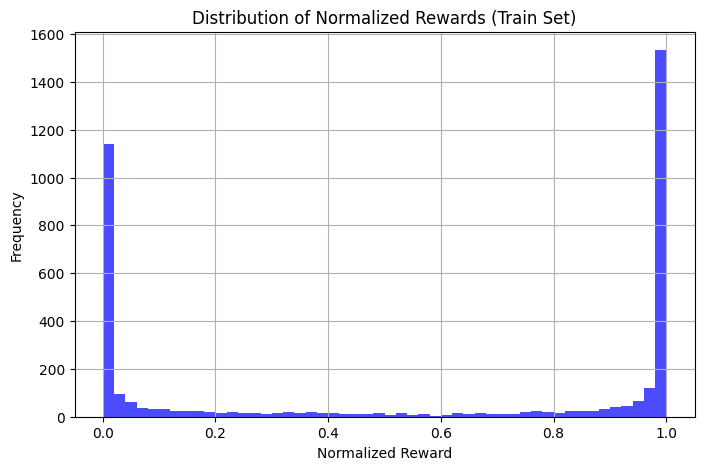

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(N2_df["normalized_reward"], bins=50, alpha=0.7, color='blue')
plt.xlabel("Normalized Reward")
plt.ylabel("Frequency")
plt.title("Distribution of Normalized Rewards (Train Set)")
plt.grid(True)
plt.show()

Create normalized_reward for the test set.

In [70]:
# For each question, find the row where N=1 and method=best_of_n, and get its 'sl' value.
# Create a new column 'best_of_1_reward' in df_test_classified with this value for each question.

# First, get the best_of_1 sl values for each question
bon_sl = df_test_classified[(df_test_classified["N"] == 1) & (df_test_classified["method"] == "best_of_n")][["question", "sl"]]
bon_sl = bon_sl.rename(columns={"sl": "best_of_1_reward"})

# Merge this back into the original dataframe
df_test_classified_after_bon = df_test_classified.merge(bon_sl, on="question", how="left")

In [71]:
df_test_classified_after_bon['question'].nunique(), df_test_classified_after_bon.shape

(983, (23692, 18))

In [72]:
# keep only the rows in df_train_classified_after_bon that are in df_train_classified.
df_test_classified_after_bon = df_test_classified_after_bon[df_test_classified_after_bon.index.isin(df_test_classified.index)]
df_test_classified_after_bon.shape

(22298, 18)

In [73]:
import scipy.special
df_test_classified_after_bon["normalized_reward"] = scipy.special.expit(df_test_classified_after_bon["sl"] - df_test_classified_after_bon["best_of_1_reward"])

In [75]:
len(df_test_classified_after_bon["normalized_reward"]), len(df_test_classified)

(22298, 22298)

In [ ]:
# Find and display rows with null values in the training set's'normalized_reward'
null_rows = df_train_classified_after_bon[df_train_classified_after_bon["normalized_reward"].isnull()]
print(f"Number of nulls: {null_rows.shape[0]}")
null_rows['question'].unique()

Number of nulls: 77


array(['["in less than 70 words please write an email declining this offer \'Dear Hussain,\\n\\nTrust my mail finds you well.\\n\\nCongratulations from Lamprell Saudi Arabia.\\n\\nWe are pleased to extend you our offer of employment for the position of \\u201cGraduate Engineer as part of Internship Programme\\u201d in our Projects Department.\\n\\nThank you for your time and support throughout the process.  \\n\\nAttached are scanned copies of the following . \\n\\nA)       Lamprell offer of Internship\\n\\nB)       Statement of Employment \\u2013 Your Contract of Employment\\n\\nC)       Your Guide working with Lamprell\\n\\nD)       Declaration Form\\n\\nE)     Fit for duty certificate\\n\\nCan I request you to please read through the attached documents and fill and sign and forward them to me. We would appreciate to receive your acceptance by Close of Business Today.\\n\\nWe are excited about the prospect of you joining our team.  \\n\\nShould you have any queries please feel free t

four questions in the training set did not have a best_of_1 score. We filled in the mean normalized_reward for normalized reward here.

In [101]:
df_train_classified_after_bon["normalized_reward"].fillna(df_train_classified_after_bon["normalized_reward"].mean(), inplace=True)

/tmp/ipykernel_470267/400844134.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_classified_after_bon["normalized_reward"].fillna(df_train_classified_after_bon["normalized_reward"].mean(), inplace=True)


one question in the test set did not have a best_of_1 score. We filled in the mean normalized_reward for normalized reward here.

In [ ]:
# Find and display rows with null values in the test set's'normalized_reward'
null_rows = df_test_classified_after_bon[df_test_classified_after_bon["normalized_reward"].isnull()]
print(f"Number of nulls: {null_rows.shape[0]}")
null_rows['question'].unique()

Number of nulls: 18


array(['["gender is a social construct about the roles, norms and social expectations given to each sexes, right ? So then by definition it\'s not about being a man or a woman, but being masculine or feminine. So in the end, why people wrongly use that to define \\"man\\" and \\"woman\\" ?","My point is that \\"non-binary, genderqueer\\" and such are not in the same category as men and women. A man can be feminine or masculine or neither, and the same for a woman. Gender is basically a part of the personality, and even if it can be influenced by biology, it\'s a stereotype, and it doesn\'t change the fact that people consider \\"man\\" and \\"woman\\" to be \\"genders\\" while it\'s \\"masculine\\" and \\"feminine\\" that should be, and \\"non binary\\" and such should be in the same category as masculine and feminine and not man and woman.","let me reiterate what is the reality: there is 2 sexes: male and female, then a man is an adult male and a woman an adult female. People can be m

In [103]:
df_test_classified_after_bon["normalized_reward"].fillna(df_test_classified_after_bon["normalized_reward"].mean(), inplace=True)

/tmp/ipykernel_470267/4160390697.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test_classified_after_bon["normalized_reward"].fillna(df_test_classified_after_bon["normalized_reward"].mean(), inplace=True)


In [105]:
# Find and display rows with null values in the test set's'normalized_reward'
null_rows = df_test_classified_after_bon[df_test_classified_after_bon["normalized_reward"].isnull()]
print(f"Number of nulls: {null_rows.shape[0]}")
null_rows['question'].unique()

Number of nulls: 0


array([], dtype=object)

save normalized scores as the response, y (for probe training).

In [ ]:
# np.save("/dccstor/gma2/mehuldamani/search-and-learn/rewards_normalized/y_train.npy", df_train_classified_after_bon["normalized_reward"].values)
# np.save("/dccstor/gma2/mehuldamani/search-and-learn/rewards_normalized/y_test.npy", df_test_classified_after_bon["normalized_reward"].values)
import numpy as np
# y_train = np.load("/dccstor/gma2/mehuldamani/search-and-learn/rewards_normalized/y_train.npy")
# y_test = np.load("/dccstor/gma2/mehuldamani/search-and-learn/rewards_normalized/y_test.npy")

In [108]:
np.isnan(y_train).sum(), np.isnan(y_test).sum()

(0, 0)

In [23]:
# df_test_classified[(df_test_classified["N"] == 1) & (df_test_classified["method"] == "best_of_n")].head()

In [24]:
import scipy.special
df_test_classified["normalized_reward"] = scipy.special.expit(df_test_classified["sl"] - df_test_classified["best_of_1_reward"])
df_test_classified.head()

,question,completions,best_completion,scores,token_count,time,sl,N,beam_width,max_iteration,method,method_beam,method_bon,token_count_pred,time_pred,calibrated_probs,type,best_of_1_reward,normalized_reward
0,"[""What's the best first move in tic-tac-toe?"",...","[""The best first move in tic-tac-toe depends o...",The best first move in tic-tac-toe depends on ...,"[[0.933034718, 0.933034718]]",184,0.889693,2.703125,1,2,5,beam_search,1,0,276.202228,1.518778,-3.576271,Other,-11.437500,0.999999
1,"[""What is \""The Bloody Lip Bar and Grill\""?""]","['Unfortunately, I\'m unable to provide detail...","Unfortunately, I'm unable to provide details a...","[[0.8751049042, 0.8751049042]]",129,0.712318,2.093750,1,2,5,beam_search,1,0,276.202228,1.518778,-6.807857,General Knowledge,-2.484375,0.989830
2,"[""could you tell a funny and whimsical story a...","['Sure, I can craft a fun and whimsical story ...","Sure, I can craft a fun and whimsical story fo...","[[0.5337949395, 0.5337949395]]",781,2.719791,-14.687500,1,2,5,beam_search,1,0,276.202228,1.518778,-3.901524,Writing-Creative,-4.375000,0.000033
3,"[""I have frozen cod filets, tomatoes, lemons, ...",['Certainly! Here are some dinner ideas that y...,Certainly! Here are some dinner ideas that you...,"[[0.6255370975, 0.6255370975]]",145,0.839499,-11.250000,1,2,5,beam_search,1,0,276.202228,1.518778,-6.146091,Advice-Opinion,-12.250000,0.731059
4,"[""The following is a command that the user is ...",['YES'],YES,"[[0.8367722034, 0.8367722034]]",6,0.212820,11.062500,1,2,5,beam_search,1,0,276.202228,1.518778,0.097095,Other,-14.062500,1.000000


In [4]:
import numpy as np

x_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/test-features/X.npy"
x = np.load(x_path)
print(x.shape)

(22298, 1542)


(pause here to create features.)

In [15]:
import numpy as np

x_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/train-features/X.npy"
y_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/train-features/y.npy"
x = np.load(x_path)
y = np.load(y_path)
print(x.shape, y.shape)


(88852, 1542) (88852,)


In [12]:
df_train_classified.shape, x.shape

((88852, 14), (88852, 1542))

# Subset features and response according to type 
(save for training.)

In [19]:
# Subset df_train_classified for all types and save as .npy files
types = df_train_classified["type"].unique()

for t in types:
    indices = df_train_classified[df_train_classified["type"] == t].index
    x_type = x[indices]
    y_type = y[indices]
    type_name = t.replace(" ", "_").replace("-", "_").lower()
    np.save(f"/dccstor/gma2/mehuldamani/search-and-learn/sept-19/{type_name}_x_train.npy", x_type)
    np.save(f"/dccstor/gma2/mehuldamani/search-and-learn/sept-19/{type_name}_y_train.npy", y_type)

Do the same for the test set.

In [20]:
import numpy as np

x_test_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/test-features/X.npy"
y_test_path = "/dccstor/gma2/mehuldamani/search-and-learn/chat-training-3/test-features/y.npy"
x_test = np.load(x_test_path)
y_test = np.load(y_test_path)
print(x_test.shape, y_test.shape)

(22298, 1542) (22298,)


In [22]:
# Subset df_test_classified for all types and save as .npy files
types = df_test_classified["type"].unique()

for t in types:
    indices = df_test_classified[df_test_classified["type"] == t].index
    x_type = x_test[indices]
    y_type = y_test[indices]
    type_name = t.replace(" ", "_").replace("-", "_").lower()
    np.save(f"/dccstor/gma2/mehuldamani/search-and-learn/sept-19/{type_name}_x_test.npy", x_type)
    np.save(f"/dccstor/gma2/mehuldamani/search-and-learn/sept-19/{type_name}_y_test.npy", y_type)

train topic-specific probes.

In [ ]:
# bsub -gpu "num=1/task:mode=exclusive_process:gmodel=NVIDIAA100_SXM4_80GB" -M 200G -J math-model4 -oo /dccstor/gma2/mehuldamani/search-and-learn/sept-19/math-model/train.out -eo /dccstor/gma2/mehuldamani/search-and-learn/sept-19/math-model/train.err python scripts/training/chat_train_calib.py \
#    --X_train /dccstor/gma2/mehuldamani/search-and-learn/sept-19/mathematics_x_train.npy \
#    --y_train /dccstor/gma2/mehuldamani/search-and-learn/sept-19/mathematics_y_train.npy \
#    --X_test /dccstor/gma2/mehuldamani/search-and-learn/sept-19/mathematics_x_test.npy \
#    --y_test /dccstor/gma2/mehuldamani/search-and-learn/sept-19/mathematics_y_test.npy \
#    --output_dir /dccstor/gma2/mehuldamani/search-and-learn/sept-19/math-model

In [25]:
# load in method-specific predicted probabilities.
ys = np.load("/dccstor/gma2/mehuldamani/search-and-learn/sept-19/mathematics_y_test.npy")
calibrated_probs_math = np.load("/dccstor/gma2/mehuldamani/search-and-learn/sept-19/math-model/model_scores_calibrated.npy")

print(calibrated_probs_math.shape, calibrated_probs_math.min().item(), calibrated_probs_math.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs_math.shape

(1450,) -11.981941223144531 25.226600646972656
(1450,) -30.625 41.25


((1450,), (1450,))

In [90]:
# load in completed predicted probabilities.
ys = np.load("/dccstor/gma2/mehuldamani/search-and-learn/rewards_normalized/y_test.npy")
calibrated_probs = np.load("/dccstor/gma2/mehuldamani/search-and-learn/rewards_normalized/model/calibrated_probs.npy")
true_labels = np.load("/dccstor/gma2/mehuldamani/search-and-learn/rewards_normalized/model/true_labels.npy")

print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs.shape

(22298,) nan nan
(22298,) nan nan


((22298,), (22298,))

In [ ]:
df_test_classified['calibrated_probs'] = calibrated_probs

# Subset question types.

In [26]:
math_subset = df_test_classified[df_test_classified["type"] == 'Mathematics']
writing_subset = df_test_classified[df_test_classified["type"] == 'Writing-Creative']
programming_subset = df_test_classified[df_test_classified["type"] == 'Programming']
advice_subset = df_test_classified[df_test_classified["type"] == 'Advice-Opinion']
other_subset = df_test_classified[df_test_classified["type"] == 'Other']
general_knowledge_subset = df_test_classified[df_test_classified["type"] == 'General Knowledge']
translation_subset = df_test_classified[df_test_classified["type"] == 'Translation']

In [27]:
math_subset['calibrated_probs'] = calibrated_probs_math

/tmp/ipykernel_3801685/2266157243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  math_subset['calibrated_probs'] = calibrated_probs_math


In [29]:
writing_subset = writing_subset.drop(columns=["token_count_pred", "time_pred"], errors="ignore")
programming_subset = programming_subset.drop(columns=["token_count_pred", "time_pred"], errors="ignore")
advice_subset = advice_subset.drop(columns=["token_count_pred", "time_pred"], errors="ignore")
math_subset = math_subset.drop(columns=["token_count_pred", "time_pred"], errors="ignore")
other_subset = other_subset.drop(columns=["token_count_pred", "time_pred"], errors="ignore")
general_knowledge_subset = general_knowledge_subset.drop(columns=["token_count_pred", "time_pred"], errors="ignore")
translation_subset = translation_subset.drop(columns=["token_count_pred", "time_pred"], errors="ignore")


In [30]:
df_train_math_subset = df_train_classified[df_train_classified["type"] == 'Mathematics']
df_train_writing_subset = df_train_classified[df_train_classified["type"] == 'Writing-Creative']
df_train_programming_subset = df_train_classified[df_train_classified["type"] == 'Programming']
df_train_advice_subset = df_train_classified[df_train_classified["type"] == 'Advice-Opinion']
df_train_other_subset = df_train_classified[df_train_classified["type"] == 'Other']
df_train_general_knowledge_subset = df_train_classified[df_train_classified["type"] == 'General Knowledge']
df_train_translation_subset = df_train_classified[df_train_classified["type"] == 'Translation']

# Routing Results.

In [ ]:
# all subsets.
groups_mean_all = df_train_classified.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
groups_mean_all = groups_mean_all.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})
df_train_classified = df_train_classified.merge(groups_mean_all, on=["method", "N", "beam_width", "max_iteration"], how="left")

In [ ]:
# Create new columns for predicted token count and time based on group means for each subset


# Mathematics
group_means_math = df_train_math_subset.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
group_means_math = group_means_math.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})
math_subset = math_subset.merge(group_means_math, on=["method", "N", "beam_width", "max_iteration"], how="left")

# Writing-Creative
group_means_writing = df_train_writing_subset.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
group_means_writing = group_means_writing.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})
writing_subset = writing_subset.merge(group_means_writing, on=["method", "N", "beam_width", "max_iteration"], how="left")

# Programming
group_means_programming = df_train_programming_subset.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
group_means_programming = group_means_programming.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})
programming_subset = programming_subset.merge(group_means_programming, on=["method", "N", "beam_width", "max_iteration"], how="left")

# Advice-Opinion
group_means_advice = df_train_advice_subset.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
group_means_advice = group_means_advice.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})
advice_subset = advice_subset.merge(group_means_advice, on=["method", "N", "beam_width", "max_iteration"], how="left")

# Other
group_means_other = df_train_other_subset.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
group_means_other = group_means_other.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})
other_subset = other_subset.merge(group_means_other, on=["method", "N", "beam_width", "max_iteration"], how="left")

# General Knowledge
group_means_general_knowledge = df_train_general_knowledge_subset.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
group_means_general_knowledge = group_means_general_knowledge.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})
general_knowledge_subset = general_knowledge_subset.merge(group_means_general_knowledge, on=["method", "N", "beam_width", "max_iteration"], how="left")

# Translation
group_means_translation = df_train_translation_subset.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
group_means_translation = group_means_translation.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})
translation_subset = translation_subset.merge(group_means_translation, on=["method", "N", "beam_width", "max_iteration"], how="left")


In [32]:
math_subset['question'].nunique(), writing_subset['question'].nunique(), programming_subset['question'].nunique(), advice_subset['question'].nunique(), other_subset['question'].nunique(), general_knowledge_subset['question'].nunique(), translation_subset['question'].nunique()

(68, 90, 151, 57, 385, 182, 50)

In [52]:
# get the average accuracy and token_count for each configuration.
config_summary_df = math_subset.groupby(["N", "beam_width", "max_iteration", "method"])[
    ["token_count", "time", "sl", "calibrated_probs", "token_count_pred", "time_pred"]
].mean().reset_index()

In [35]:
config_summary_df.head()

,N,beam_width,max_iteration,method,token_count,time,sl,calibrated_probs,token_count_pred,time_pred
0,1,1,1,best_of_n,978.927536,4.922264,-1.740065,3.572360,931.623431,4.681484
1,1,2,5,beam_search,290.117647,2.702683,1.370404,2.976859,363.209091,2.849151
2,1,2,10,beam_search,503.510638,5.341195,2.452565,2.985168,553.907514,4.858130
3,1,2,40,beam_search,828.885714,11.645678,5.092634,5.789084,783.635593,8.008406
4,1,4,5,beam_search,704.161290,3.734621,2.388105,2.136857,775.911765,3.268064


In [37]:
df_test_classified['type'].unique()

array(['Other', 'General Knowledge', 'Writing-Creative', 'Advice-Opinion',
       'Programming', 'Mathematics', 'Translation'], dtype=object)

In [38]:
math_subset_bon = df_test_classified[(df_test_classified["type"] == 'Mathematics') & (df_test_classified["method"] == "best_of_n")]
writing_subset_bon = df_test_classified[(df_test_classified["type"] == 'Writing-Creative') & (df_test_classified["method"] == "best_of_n")]
programming_subset_bon = df_test_classified[(df_test_classified["type"] == 'Programming') & (df_test_classified["method"] == "best_of_n")]
advice_subset_bon = df_test_classified[(df_test_classified["type"] == 'Advice-Opinion') & (df_test_classified["method"] == "best_of_n")]
other_subset_bon = df_test_classified[(df_test_classified["type"] == 'Other') & (df_test_classified["method"] == "best_of_n")]
general_knowledge_subset_bon = df_test_classified[(df_test_classified["type"] == 'General Knowledge') & (df_test_classified["method"] == "best_of_n")]
translation_subset_bon = df_test_classified[(df_test_classified["type"] == 'Translation') & (df_test_classified["method"] == "best_of_n")]

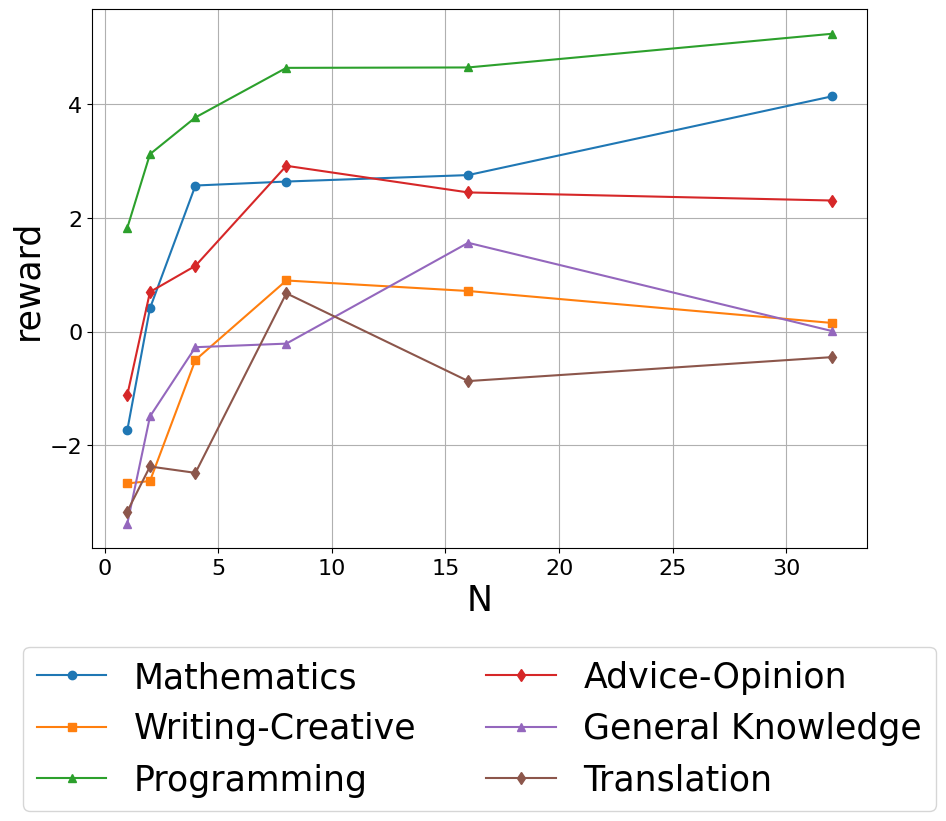

In [350]:
import matplotlib.pyplot as plt

# Set font sizes for clarity
label_fontsize = 25
tick_fontsize = 16  # Reduced x-axis text size as requested
title_fontsize = 35
annot_fontsize = 22

# Group by N and calculate mean sl for each subset
math_n_sl = math_subset_bon.groupby("N")["sl"].mean().reset_index()
writing_n_sl = writing_subset_bon.groupby("N")["sl"].mean().reset_index()
programming_n_sl = programming_subset_bon.groupby("N")["sl"].mean().reset_index()
advice_n_sl = advice_subset_bon.groupby("N")["sl"].mean().reset_index()
# other_n_sl = other_subset_bon.groupby("N")["sl"].mean().reset_index()
general_knowledge_n_sl = general_knowledge_subset_bon.groupby("N")["sl"].mean().reset_index()
translation_n_sl = translation_subset_bon.groupby("N")["sl"].mean().reset_index()

plt.figure(figsize=(10,7))
plt.plot(math_n_sl["N"], math_n_sl["sl"], marker='o', label="Mathematics")
plt.plot(writing_n_sl["N"], writing_n_sl["sl"], marker='s', label="Writing-Creative")
plt.plot(programming_n_sl["N"], programming_n_sl["sl"], marker='^', label="Programming")
plt.plot(advice_n_sl["N"], advice_n_sl["sl"], marker='d', label="Advice-Opinion")
# plt.plot(other_n_sl["N"], other_n_sl["sl"], marker='s', label="Other")
plt.plot(general_knowledge_n_sl["N"], general_knowledge_n_sl["sl"], marker='^', label="General Knowledge")
plt.plot(translation_n_sl["N"], translation_n_sl["sl"], marker='d', label="Translation")
plt.xlabel("N", fontsize=label_fontsize)
plt.ylabel("reward", fontsize=label_fontsize)
# plt.title("N vs reward by topic", fontsize=title_fontsize)
plt.grid(True)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=label_fontsize, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

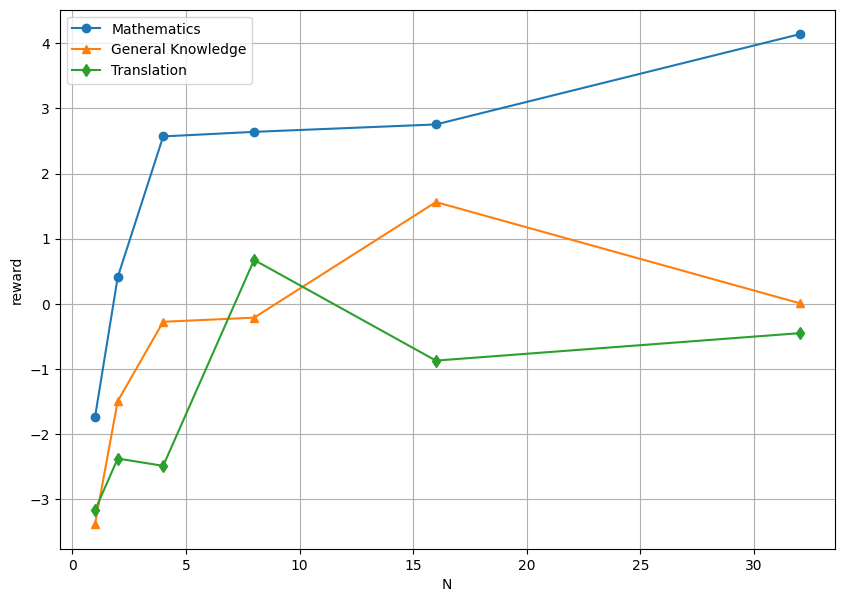

In [310]:
import matplotlib.pyplot as plt

# Group by N and calculate mean sl for each subset
math_n_sl = math_subset_bon.groupby("N")["sl"].mean().reset_index()
# other_n_sl = other_subset_bon.groupby("N")["sl"].mean().reset_index()
general_knowledge_n_sl = general_knowledge_subset_bon.groupby("N")["sl"].mean().reset_index()
translation_n_sl = translation_subset_bon.groupby("N")["sl"].mean().reset_index()

plt.figure(figsize=(10,7))
plt.plot(math_n_sl["N"], math_n_sl["sl"], marker='o', label="Mathematics")
# plt.plot(other_n_sl["N"], other_n_sl["sl"], marker='s', label="Other")
plt.plot(general_knowledge_n_sl["N"], general_knowledge_n_sl["sl"], marker='^', label="General Knowledge")
plt.plot(translation_n_sl["N"], translation_n_sl["sl"], marker='d', label="Translation")
plt.xlabel("N")
plt.ylabel("reward")
# plt.title("N vs reward by topic")
plt.grid(True)
plt.legend()
plt.show()

In [39]:
def compute_max_utility_pred(df, lambda_, method="oracle", costa="token_count", costb="time", fixed_lambda=0):
    def get_max_utility(group):
        group = group.copy()
        if method == "oracle":
            group["utility"] = group["sl"] - lambda_ * group[costa] - fixed_lambda * group[costb]
        elif method == "adaptive_router":
            group["utility"] = group["calibrated_probs"] - lambda_ * group[costa] - fixed_lambda * group[costb]
        else:
            raise ValueError(f"Invalid method: {method}")
        idx_max = group["utility"].idxmax()

        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "calibrated_probs"],
            "max_sl": group.loc[idx_max, "sl"],
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "beam_width": group.loc[idx_max, "beam_width"],
            "max_iteration": group.loc[idx_max, "max_iteration"],
            "method": group.loc[idx_max, "method"] # sept 3rd. added method.
        })

    result_df = df.groupby("question").apply(get_max_utility).reset_index()
    return result_df

In [40]:
def get_router_df(input_df, lambda_list, method="oracle", costa="token_count", costb="time", fixed_lambda=0):
    results = []

    for lambda_value in lambda_list:
        adaptive_router = compute_max_utility_pred(input_df, lambda_value, method, costa, costb, fixed_lambda)
        average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
        average_cost = adaptive_router["max_cost"].mean() # average over all questions in test set for adaptive router.
        average_time = adaptive_router["max_time"].mean()
        average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
        
        results.append({
            "lambda": lambda_value,
            "sl": average_accuracy,
            "predicted_prob": average_predicted_prob,
            "token_count": average_cost,
            "time": average_time,
        })

    # Convert to DataFrame
    output_df = pd.DataFrame(results)
    output_df["method"] = method

    return output_df

In [68]:
import math


oracle_tc = get_router_df(math_subset, lambda_list=np.logspace(-20, -1, num=25), method="oracle", costa="token_count", costb="time", fixed_lambda=0) # (input_df, lambda_list, method="oracle", costa="token_count", costb="time", fixed_lambda=0)
adaptive_tc = get_router_df(math_subset, lambda_list=np.logspace(-20, -1, num=25), method="adaptive_router", costa="token_count_pred", costb="time_pred", fixed_lambda=0)
adaptive_oracle_tc = get_router_df(math_subset, lambda_list=np.logspace(-20, -1, num=25), method="adaptive_router", costa="token_count", costb="time", fixed_lambda=0)

adaptive_oracle_lat = get_router_df(math_subset, lambda_list=np.logspace(-20, -1, num=25), method="adaptive_router", costa="time", costb="token_count", fixed_lambda=0)
adaptive_lat = get_router_df(math_subset, lambda_list=np.logspace(-20, -1, num=25), method="adaptive_router", costa="time_pred", costb="token_count_pred", fixed_lambda=0)
oracle_lat = get_router_df(math_subset, lambda_list=np.logspace(-20, -1, num=25), method="oracle", costa="time", costb="token_count", fixed_lambda=0)

/tmp/ipykernel_3801685/3274000803.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("question").apply(get_max_utility).reset_index()
/tmp/ipykernel_3801685/3274000803.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("question").apply(get_max_utility).reset_index()
/tmp/ipykernel_3801685/3274000803.py:24: FutureWarning: DataFrameGroupBy.apply operated on the groupin

In [69]:
oracle_tc['N'] = -1
oracle_tc['beam_width'] = -1
oracle_tc['max_iteration'] = -1

oracle_lat['N'] = -1
oracle_lat['beam_width'] = -1
oracle_lat['max_iteration'] = -1

adaptive_tc['N'] = -1
adaptive_tc['beam_width'] = -1
adaptive_tc['max_iteration'] = -1

adaptive_lat['N'] = -1
adaptive_lat['beam_width'] = -1
adaptive_lat['max_iteration'] = -1

adaptive_oracle_tc['N'] = -1
adaptive_oracle_tc['beam_width'] = -1
adaptive_oracle_tc['max_iteration'] = -1

adaptive_oracle_lat['N'] = -1
adaptive_oracle_lat['beam_width'] = -1
adaptive_oracle_lat['max_iteration'] = -1

In [70]:
adaptive_tc['method'] = 'adaptive_router'
adaptive_lat['method'] = 'adaptive_router'
oracle_tc['method'] = 'oracle'
oracle_lat['method'] = 'oracle'
adaptive_oracle_tc['method'] = 'adaptive_oracle'
adaptive_oracle_lat['method'] = 'adaptive_oracle'


In [71]:
# config_summary_df = config_summary_df.drop(columns=["token_count_pred", "time_pred"])
# config_summary_df.rename(columns={"eval_rm": "sl"}, inplace=True)
config_summary_df.head(5)

,N,beam_width,max_iteration,method,token_count,time,sl,calibrated_probs,token_count_pred,time_pred
0,1,1,1,best_of_n,978.927536,4.922264,-1.740065,3.572360,931.623431,4.681484
1,1,2,5,beam_search,290.117647,2.702683,1.370404,2.976859,363.209091,2.849151
2,1,2,10,beam_search,503.510638,5.341195,2.452565,2.985168,553.907514,4.858130
3,1,2,40,beam_search,828.885714,11.645678,5.092634,5.789084,783.635593,8.008406
4,1,4,5,beam_search,704.161290,3.734621,2.388105,2.136857,775.911765,3.268064


In [72]:
# merge all token count dataframes.
query_optimal_tc = pd.concat(
    [config_summary_df, adaptive_tc, adaptive_oracle_tc, oracle_tc],
    axis=0,          # stack them vertically (rows)
    ignore_index=True  # reset the index
)

In [73]:
query_optimal_tc['method'].unique()

array(['best_of_n', 'beam_search', 'adaptive_router', 'adaptive_oracle',
       'oracle'], dtype=object)

In [74]:
# merge all latency dataframes.
query_optimal_late = pd.concat(
    [config_summary_df, adaptive_lat, adaptive_oracle_lat, oracle_lat],
    axis=0,          # stack them vertically (rows)
    ignore_index=True  # reset the index
)

In [75]:
query_optimal_late['method'].unique()

array(['best_of_n', 'beam_search', 'adaptive_router', 'adaptive_oracle',
       'oracle'], dtype=object)

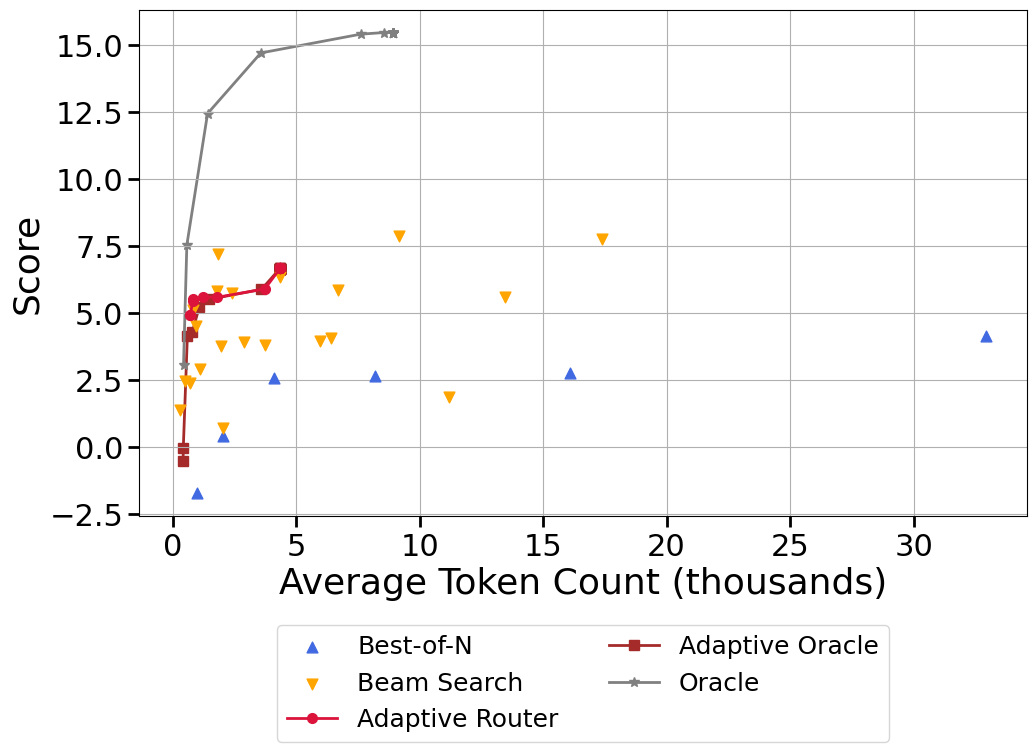

In [76]:
# Plot for token_count (cost) vs accuracy.

import matplotlib.pyplot as plt

# Only these methods will be plotted
methods_to_plot = ['best_of_n', 'beam_search', 'adaptive_router', 'adaptive_oracle', 'oracle']

# Assign colors and markers for each method
method_colors = {
    "best_of_n": "royalblue",
    "beam_search": "orange",
    "adaptive_router": "crimson",
    "adaptive_oracle": "brown",
    "oracle": "gray"
}
method_markers = {
    "best_of_n": ("^", "-."),      # triangle_up, dash-dot
    "beam_search": ("v", "--"),    # triangle_down, dashed
    "adaptive_router": ("o", "-"), # circle, solid
    "adaptive_oracle": ("s", "-"), # square, solid
    "oracle": ("*", "-")           # star, solid
}
method_labels = {
    "best_of_n": "Best-of-N",
    "beam_search": "Beam Search",
    "adaptive_router": "Adaptive Router",
    "adaptive_oracle": "Adaptive Oracle",
    "oracle": "Oracle"
}

plt.figure(figsize=(10, 6))
handles = []
labels = []

for method in methods_to_plot:
    if method in query_optimal_tc["method"].unique():
        method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
        color = method_colors.get(method, "black")
        marker, linestyle = method_markers.get(method, ("o", "-"))
        label = method_labels.get(method, method)
        # For beam_search and best_of_n, use scatter for clarity
        if method in ["beam_search", "best_of_n"]:
            h = plt.scatter(
                method_df["token_count"] / 1000,
                method_df["sl"],
                marker=marker,
                color=color,
                label=label,
                s=60,
                zorder=2
            )
        else:
            h, = plt.plot(
                method_df["token_count"] / 1000,
                method_df["sl"],
                marker=marker,
                linestyle=linestyle,
                color=color,
                label=label,
                markersize=7,
                linewidth=2,
                zorder=3 if method == "adaptive_router" else 1
            )
        handles.append(h)
        labels.append(label)

plt.xlabel("Average Token Count (thousands)", fontsize=26)
plt.ylabel("Score", fontsize=26)
plt.grid(True)
plt.tight_layout()

plt.legend(
    handles,
    labels,
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.19),
    ncol=2,
    frameon=True
)

plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)

plt.show()

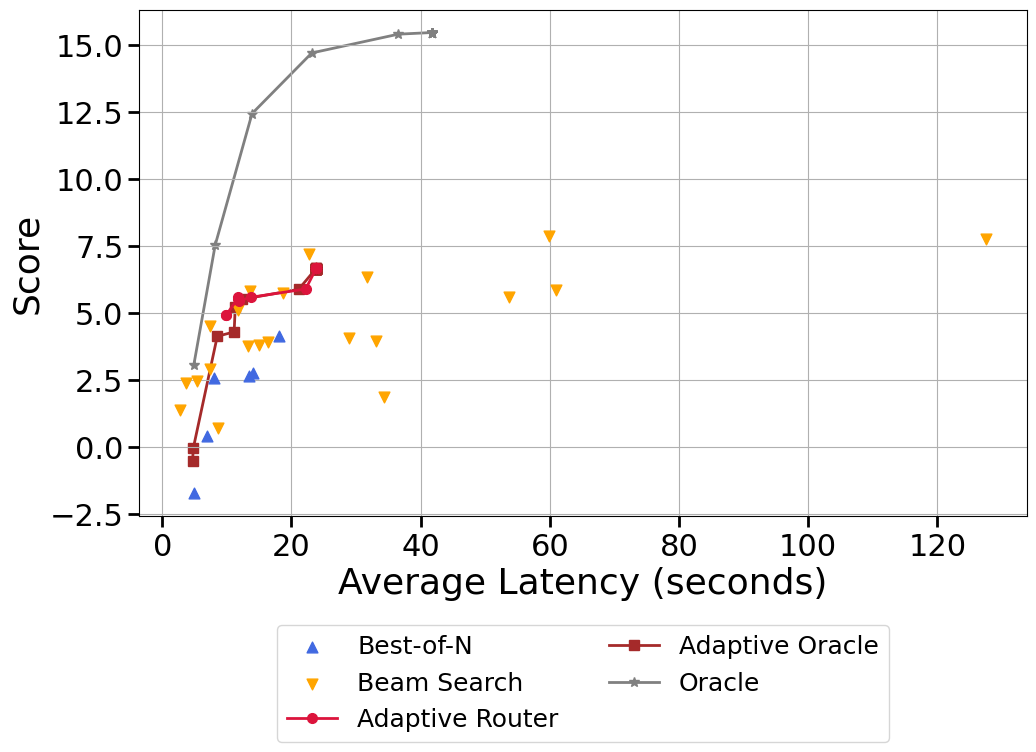

In [77]:
# Plot for time (latency) vs accuracy for only the five methods of interest

import matplotlib.pyplot as plt

# Only these methods will be plotted
methods_to_plot = ['best_of_n', 'beam_search', 'adaptive_router', 'adaptive_oracle', 'oracle']

# Assign colors and markers for each method
method_colors = {
    "best_of_n": "royalblue",
    "beam_search": "orange",
    "adaptive_router": "crimson",
    "adaptive_oracle": "brown",
    "oracle": "gray"
}
method_markers = {
    "best_of_n": ("^", "-."),      # triangle_up, dash-dot
    "beam_search": ("v", "--"),    # triangle_down, dashed
    "adaptive_router": ("o", "-"), # circle, solid
    "adaptive_oracle": ("s", "-"), # square, solid
    "oracle": ("*", "-")           # star, solid
}
method_labels = {
    "best_of_n": "Best-of-N",
    "beam_search": "Beam Search",
    "adaptive_router": "Adaptive Router",
    "adaptive_oracle": "Adaptive Oracle",
    "oracle": "Oracle"
}

plt.figure(figsize=(10, 6))
handles = []
labels = []

for method in methods_to_plot:
    if method in query_optimal_tc["method"].unique():
        method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("time")
        color = method_colors.get(method, "black")
        marker, linestyle = method_markers.get(method, ("o", "-"))
        label = method_labels.get(method, method)
        # For beam_search and best_of_n, use scatter for clarity
        if method in ["beam_search", "best_of_n"]:
            h = plt.scatter(
                method_df["time"],
                method_df["sl"],
                marker=marker,
                color=color,
                label=label,
                s=60,
                zorder=2
            )
        else:
            h, = plt.plot(
                method_df["time"],
                method_df["sl"],
                marker=marker,
                linestyle=linestyle,
                color=color,
                label=label,
                markersize=7,
                linewidth=2,
                zorder=3 if method == "adaptive_router" else 1
            )
        handles.append(h)
        labels.append(label)

plt.xlabel("Average Latency (seconds)", fontsize=26)
plt.ylabel("Score", fontsize=26)
plt.grid(True)
plt.tight_layout()

plt.legend(
    handles,
    labels,
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.19),
    ncol=2,
    frameon=True
)

plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)

plt.show()

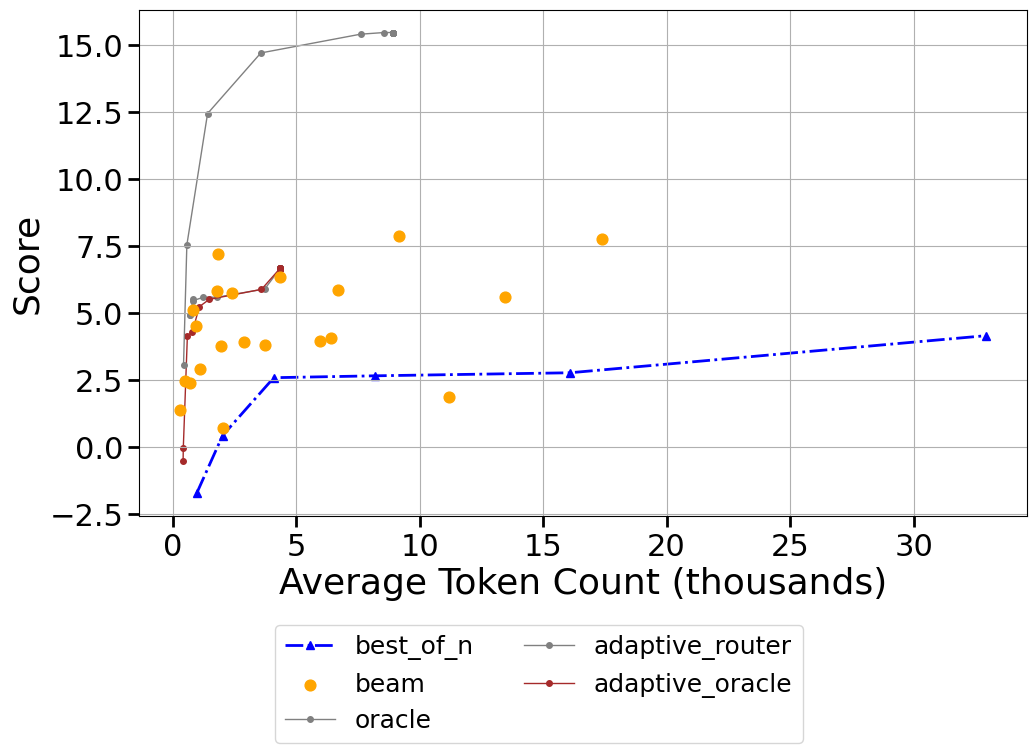

In [78]:
# router on latency, cross sections with various lambda values.
# Use different shades of red for each adaptive_router variant
import matplotlib.pyplot as plt

# Plot for token_count (cost) vs accuracy, using the same style as the latency plot above

method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router_2": "#990000",  # very dark red
    "adaptive_router_3": "#e60000",  # dark red
    "adaptive_router_4": "#ff4d4d",  # medium red
    "adaptive_router_0": "#ff9999",  # light red
    "oracle": "gray",  # Oracle router
    "adaptive_oracle": "brown",  # Query-adaptive router with oracle cost
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "best_of_n": "blue"
}

# Mapping for pretty legend names for adaptive_router_X
adaptive_router_legend = {
    "adaptive_router_0": r"adaptive ($\lambda_L  = 0$)",
    "adaptive_router_2": r"adaptive ($\lambda_L = 10^{-2}$)",
    "adaptive_router_3": r"adaptive ($\lambda_L = 10^{-3}$)",
    "adaptive_router_4": r"adaptive ($\lambda_L = 10^{-4}$)",
    "beam_search": r"beam",
}

# Marker and linestyle mapping for specific methods
method_markers = {
    # "majority": ("s", "--"),   # square, dashed
    "best_of_n": ("^", "-."),      # triangle_up, dash-dot
    # "weighted": ("D", ":"),    # diamond, dotted
    # "beam_search": ("v", "--"), # triangle_down, dashed
}
default_marker = "o"
default_linestyle = "-"

plt.figure(figsize=(10, 6))

handles = []
labels = []

# Define the plotting order for adaptive_router_X to control z-order
adaptive_router_order = ["adaptive_router_0", "adaptive_router_4", "adaptive_router_3", "adaptive_router_2"]

# First, plot all non-adaptive_router_X methods (except oracle_cost)
for method in query_optimal_tc["method"].unique():
    if not method.startswith("adaptive_router_") and method != "oracle_cost":
        method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
        color = method_colors.get(method, "gray")
        marker, linestyle = method_markers.get(method, (default_marker, default_linestyle))
        if method == "beam_search":
            label = adaptive_router_legend.get(method, method)
            # For beam_search, plot only points (no lines)
            h = plt.scatter(
                method_df["token_count"] / 1000,
                method_df["sl"],
                marker=marker,
                color=color,
                label=label,
                s=60,  # marker size
                zorder=2
            )
        else:
            label = method
            h, = plt.plot(
                method_df["token_count"] / 1000, 
                method_df["sl"], 
                marker=marker, 
                linestyle=linestyle, 
                color=color, 
                label=label,
                markersize=6 if method in method_markers else 4,
                linewidth=2 if method in method_markers else 1,
                zorder=1
            )
        handles.append(h)
        labels.append(label)

# Then, plot adaptive_router_X in the desired order so that 2 is on top, then 3, then 4, then 0
for idx, method in enumerate(adaptive_router_order):
    if method in query_optimal_tc["method"].unique():
        method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
        color = method_colors.get(method, "red")
        label = adaptive_router_legend.get(method, method)
        # order increases with idx, so last (adaptive_router_2) is on top
        # Plot token_count in thousands
        h, = plt.plot(
            method_df["token_count"] / 1000, 
            method_df["sl"], 
            marker=default_marker, 
            linestyle=default_linestyle, 
            color=color, 
            label=label,
            markersize=6,
            linewidth=2,
            zorder=10 + idx  # ensure these are above the others
        )
        handles.append(h)
        labels.append(label)

plt.xlabel("Average Token Count (thousands)", fontsize=26)
plt.ylabel("Score", fontsize=26)
plt.grid(True)
# plt.ylim(0.25, 0.6)
plt.tight_layout()

# --- REARRANGE LEGEND SO ALL ADAPTIVE METHODS (INCLUDING LAMBDA=0) ARE ON THE RIGHT ---
# AND adaptive lambda_l = 0 IS ABOVE adaptive lambda_l = 1e-4 ---

adaptive_labels = []
adaptive_handles = []
other_labels = []
other_handles = []

# Collect adaptive methods and their handles for sorting
adaptive_entries = []

for h, l in zip(handles, labels):
    # Put all adaptive methods (including lambda=0) on the right
    # This includes any label that starts with "adaptive" or r"adaptive ("
    if l.startswith("adaptive") or l.startswith(r"adaptive ("):
        adaptive_entries.append((l, h))
    else:
        other_labels.append(l)
        other_handles.append(h)

# Sort adaptive entries so that lambda=0 is first (on top), then the rest
# This works for both "adaptive_router_0" and r"adaptive ($\lambda_L = 0$)" style labels
def adaptive_sort_key(entry):
    label = entry[0]
    # Try to extract lambda value if present
    import re
    # Match r"adaptive ($\lambda_L = ...$)"
    m = re.search(r"\$\\lambda_L\s*=\s*([^\$]+)\$", label)
    if m:
        val = m.group(1).strip()
        try:
            # Try to convert to float
            return float(val)
        except Exception:
            # If not a float, put at end
            return float('inf')
    # Match "adaptive_router_X"
    m2 = re.search(r"adaptive_router[_\s]*([0-9]+)", label)
    if m2:
        return float(m2.group(1))
    # If not matched, put at end
    return float('inf')

adaptive_entries_sorted = sorted(adaptive_entries, key=adaptive_sort_key)

adaptive_labels = [l for l, h in adaptive_entries_sorted]
adaptive_handles = [h for l, h in adaptive_entries_sorted]

# Compose the new legend order: non-adaptive methods first (left), then adaptive methods (right)
handles_ordered = other_handles + adaptive_handles
labels_ordered = other_labels + adaptive_labels

plt.legend(
    handles_ordered,
    labels_ordered,
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.45, -0.19),
    ncol=2,
    frameon=True
)

plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)

plt.show()

In [79]:
query_optimal_late[query_optimal_late["method"] == "best_of_n"].head()

,N,beam_width,max_iteration,method,token_count,time,sl,calibrated_probs,token_count_pred,time_pred,lambda,predicted_prob
0,1,1,1,best_of_n,978.927536,4.922264,-1.740065,3.572360,931.623431,4.681484,NaN,NaN
6,2,1,1,best_of_n,2023.857143,6.900244,0.410212,3.515278,1921.595455,6.375378,NaN,NaN
13,4,1,1,best_of_n,4096.771429,8.050099,2.569643,3.419732,3874.487288,7.934484,NaN,NaN
19,8,1,1,best_of_n,8183.956522,13.443048,2.639634,3.392972,7552.600840,9.188437,NaN,NaN
25,16,1,1,best_of_n,16085.671429,14.120972,2.753408,3.225610,15070.907173,11.562371,NaN,NaN


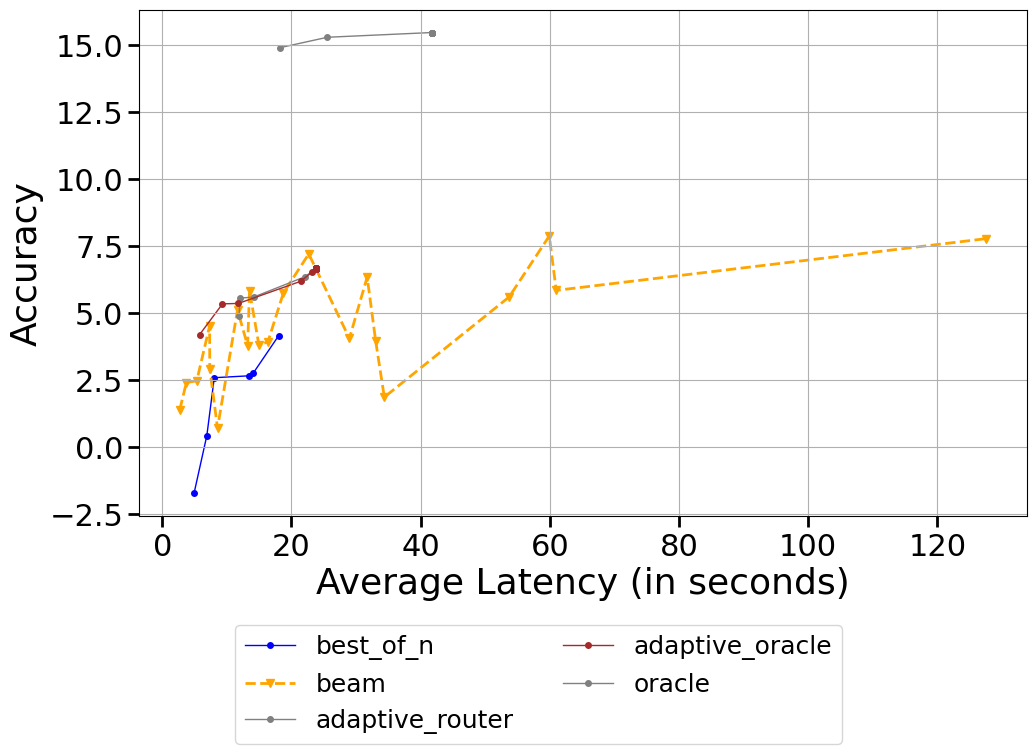

In [80]:
# router on latency, cross sections with various lambda values.
# Use different shades of red for each adaptive_router variant

method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router_5": "#990000",  # very dark red
    "adaptive_router_6": "#e60000",  # dark red
    "adaptive_router_7": "#ff4d4d",  # medium red
    "adaptive_router_0": "#ff9999",  # light red
    "oracle": "gray",  # Oracle router
    "adaptive_oracle": "brown",  # Query-adaptive router with oracle cost
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "best_of_n": "blue",
    "naive": "turquoise"
}

# Mapping for pretty legend names for adaptive_router_X
adaptive_router_legend = {
    "adaptive_router_0": r"adaptive ($\lambda_T  = 0$)",
    "adaptive_router_5": r"adaptive ($\lambda_T = 10^{-5}$)",
    "adaptive_router_6": r"adaptive ($\lambda_T = 10^{-6}$)",
    "adaptive_router_7": r"adaptive ($\lambda_T = 10^{-7}$)",
    "beam_search": r"beam",
}

# Marker and linestyle mapping for specific methods
method_markers = {
    "majority": ("s", "--"),   # square, dashed
    "naive": ("^", "-."),      # triangle_up, dash-dot
    "weighted": ("D", ":"),    # diamond, dotted
    "beam_search": ("v", "--"), # triangle_down, dashed
}
default_marker = "o"
default_linestyle = "-"

plt.figure(figsize=(10, 6))

handles = []
labels = []

# Define the plotting order for adaptive_router_X to control z-order
adaptive_router_order = ["adaptive_router_0", "adaptive_router_7", "adaptive_router_6", "adaptive_router_5"]

# First, plot all non-adaptive_router_X methods (except oracle_cost)
for method in query_optimal_late["method"].unique():
    if not method.startswith("adaptive_router_") and method != "oracle_cost":
        method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
        color = method_colors.get(method, "gray")
        marker, linestyle = method_markers.get(method, (default_marker, default_linestyle))
        if method == "beam_search":
            label = adaptive_router_legend.get(method, method)
        else:
            label = method
        h, = plt.plot(
            method_df["time"], 
            method_df["sl"], 
            marker=marker, 
            linestyle=linestyle, 
            color=color, 
            label=label,
            markersize=6 if method in method_markers else 4,
            linewidth=2 if method in method_markers else 1,
            zorder=1
        )
        handles.append(h)
        labels.append(label)

# Then, plot adaptive_router_X in the desired order so that 5 is on top, then 6, then 7, then 0
for idx, method in enumerate(adaptive_router_order):
    if method in query_optimal_late["method"].unique():
        method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
        color = method_colors.get(method, "red")
        label = adaptive_router_legend.get(method, method)
        # zorder increases with idx, so last (adaptive_router_5) is on top
        h, = plt.plot(
            method_df["time"], 
            method_df["sl"], 
            marker=default_marker, 
            linestyle=default_linestyle, 
            color=color, 
            label=label,
            markersize=6,
            linewidth=2,
            zorder=10 + idx  # ensure these are above the others
        )
        handles.append(h)
        labels.append(label)

plt.xlabel("Average Latency (in seconds)", fontsize=26)
plt.ylabel("Accuracy", fontsize=26)
plt.grid(True)
# plt.ylim(0.25, 0.6)
plt.tight_layout()

plt.legend(
    handles,
    labels,
    fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.45, -0.19),
    ncol=2,
    frameon=True
)

plt.tick_params(axis='both', which='major', length=8, width=2, labelsize=22)
plt.tick_params(axis='both', which='minor', length=5, width=1, labelsize=22)

plt.show()

### Routing Decisions.

In [81]:
# adaptive router by token count penalty.
# Plot progression of method distribution as lambda increases from 0 to 1,
# with y-axis as the proportion of questions out of total unique sb_idx.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create a range of lambda values from 0 to 1
lambda_values = np.logspace(-10, -1, num=50) 

# Get the total number of unique questions
total_questions = len(df_test['question'].unique())

# Store results for each lambda
method_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    # compute_max_utility_pred(input_df, lambda_value, method, costa, costb, fixed_lambda)
    adaptive_router = compute_max_utility_pred(df_test, lambda_val, "adaptive_router", "token_count_pred", "time_pred", fixed_lambda=0)


    # Count the frequency of each method
    method_counts = adaptive_router['method'].value_counts()
    
    # Store the distribution as proportions
    method_distributions.append({
        'lambda': lambda_val,
        'best_of_n': method_counts.get('best_of_n', 0) / total_questions,
        'beam_search': method_counts.get('beam_search', 0) / total_questions
    })

# Convert to DataFrame
dist_df = pd.DataFrame(method_distributions)

KeyError: 'calibrated_probs'